#  Prediction of accident severity in UK

### Summary
this prediction used the data from https://data.gov.uk/dataset/cb7ae6f0-4be6-4935-9277-47e5ce24a11f/road-safety-data, 
including accident circumstances, vehicle conditions, using 2015 ~ 2019 data. I excluded casaulties data and some of the accident, vehicle data that wasn't aquired before the accident happened.

## 1. Obtaining and Viewing the Data

In [1]:
# import the toolkits
import pandas as pd
import numpy as np
import glob

import matplotlib.pyplot as plt
import seaborn as sns

# suppress all warnings
import warnings
warnings.filterwarnings("ignore")

#### Accident 2015-2019

In [2]:
accidents = pd.concat([pd.read_csv(f, compression='zip', 
                                   low_memory=False) for f in glob.glob('data/*Accidents*.zip')])
print('Records:', accidents.shape[0], '\nColumns:', accidents.shape[1])
accidents.head(3)

Records: 646830 
Columns: 32


,Accident_Index,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,...,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident,LSOA_of_Accident_Location
0,201501BS70001,525130.0,180050.0,-0.198465,51.505538,1,3,1,1,12/01/2015,...,0,0,4,1,1,0,0,1,1,E01002825
1,201501BS70002,526530.0,178560.0,-0.178838,51.491836,1,3,1,1,12/01/2015,...,0,0,1,1,1,0,0,1,1,E01002820
2,201501BS70004,524610.0,181080.0,-0.205590,51.514910,1,3,1,1,12/01/2015,...,0,1,4,2,2,0,0,1,1,E01002833


#### Casualties 2015-2019

In [3]:
casualties = pd.concat([pd.read_csv(f, compression='zip') for f in glob.glob('data/*Casualties*.zip')], 
                       sort=True)
print('Records:', casualties.shape[0], '\nColumns:', casualties.shape[1])
casualties.head(3)

Records: 852321 
Columns: 16


,Accident_Index,Age_Band_of_Casualty,Age_of_Casualty,Bus_or_Coach_Passenger,Car_Passenger,Casualty_Class,Casualty_Home_Area_Type,Casualty_IMD_Decile,Casualty_Reference,Casualty_Severity,Casualty_Type,Pedestrian_Location,Pedestrian_Movement,Pedestrian_Road_Maintenance_Worker,Sex_of_Casualty,Vehicle_Reference
0,201597UA71710,10,75,0,0,1,3,-1,1,3,9,0,0,0,2,2
1,201597UA71810,9,63,4,0,2,3,-1,1,2,11,0,0,0,2,2
2,201597UA71810,10,75,4,0,2,1,-1,2,2,11,0,0,0,2,2


#### Vehicles 2015-2019

In [4]:
vehicles = pd.concat([pd.read_csv(f, compression='zip') for f in glob.glob('data/*Vehicles*.zip')], 
                     sort=True)
print('Records:', vehicles.shape[0], '\nColumns:', vehicles.shape[1])
vehicles.head(3)

Records: 1192061 
Columns: 23


,1st_Point_of_Impact,Accident_Index,Age_Band_of_Driver,Age_of_Driver,Age_of_Vehicle,Driver_Home_Area_Type,Driver_IMD_Decile,Engine_Capacity_(CC),Hit_Object_in_Carriageway,Hit_Object_off_Carriageway,...,Sex_of_Driver,Skidding_and_Overturning,Towing_and_Articulation,Vehicle_IMD_Decile,Vehicle_Leaving_Carriageway,Vehicle_Location-Restricted_Lane,Vehicle_Manoeuvre,Vehicle_Reference,Vehicle_Type,Was_Vehicle_Left_Hand_Drive?
0,3,201506E098757,7,45,11,1,-1,1794,0,0,...,1,0,0,-1,0,0,18,2,9,1
1,4,201506E098766,5,25,1,-1,-1,1582,0,0,...,2,0,0,-1,0,0,9,1,9,1
2,1,201506E098766,8,51,-1,1,-1,-1,0,0,...,1,0,0,-1,0,0,18,2,9,1


## 2. Preprocessing the data

#### 2.1 Data cleaning

The data contain some informations that are lost, this would affect the result of prediction. I drop the variables contain more
than 30% of missing value and the samples which contain any of missing data.

In [5]:
# merging data
df = pd.merge(accidents, 
              vehicles,
              on='Accident_Index', how='inner')

In [6]:
# seperate data type after the feature selection
goal_col = ['Accident_Index', 'Accident_Severity']

datetime_col = ['Date', 'Time']

num_col = ['Age_of_Driver', 'Age_of_Vehicle', 'Engine_Capacity_(CC)']

cat_col = ['1st_Road_Class', 'Road_Type', 'Speed_limit', 'Junction_Detail', 'Pedestrian_Crossing-Physical_Facilities',
           'Light_Conditions', 'Urban_or_Rural_Area', 'Junction_Location', 'Sex_of_Driver', 'Vehicle_Location-Restricted_Lane',
           'Vehicle_Manoeuvre', 'Vehicle_Type']

In [7]:
# Handling missing value
for column in df.columns:
    missing_number = (df[column] == -1).sum()
    sum_of_number = df[column].shape[0]
    if (missing_number/sum_of_number) > 0.3:
        df.drop([column], 1, inplace=True)
        print('column has been dropped: ' ,column)
        
df = df.replace(-1, np.NaN)
print(df.shape)
df = df.dropna()
print(df.shape)

column has been dropped:  Junction_Control
column has been dropped:  2nd_Road_Class
column has been dropped:  Driver_IMD_Decile
column has been dropped:  Vehicle_IMD_Decile
(1028221, 50)
(563225, 50)


#### 2.2 handling the datetime variables

Convert the datetime variables into categorical variables. Beacuase the date and time data range is too large, I classify it by people's daily routines and seasons.

In [8]:
# dealing with datetime data
df['Date'] = pd.to_datetime(df['Date'], format="%d/%m/%Y")

df['Month'] = df['Date'].dt.month

df['Hour'] = df['Time'].str[0:2]
df['Hour'] = pd.to_numeric(df['Hour'])
df = df.dropna(subset=['Hour'])
df['Hour'] = df['Hour'].astype('int')

In [9]:
# define a function that turns the month into season groups
def what_season_was_it(month):
    if month >= 3 and month < 6:
        return 1
    elif month >= 6 and month < 9:
        return 2
    elif month >= 9 and month < 12:
        return 3
    else:
        return 4
    
# define a function that turns the hours into daytime groups
def when_was_it(hour):
    if hour >= 5 and hour < 10:
        return 1
    elif hour >= 10 and hour < 15:
        return 2
    elif hour >= 15 and hour < 19:
        return 3
    elif hour >= 19 and hour < 23:
        return 4
    else:
        return 5

In [10]:
# create a little dictionary to later look up the groups I created
season_groups = {1: 'Spring: Between 3 and 5', 
                 2: 'Summer: Between 6 and 8', 
                 3: 'Fall: Between 9 and 11', 
                 4: 'Winnter: Between 12 and 2'}
 

daytime_groups = {1: 'Morning: Between 5 and 9', 
                  2: 'Office Hours: Between 10 and 14', 
                  3: 'Afternoon Rush: Between 15 and 18', 
                  4: 'Evening: Between 19 and 23', 
                  5: 'Night: Between 2 and 5'}

In [11]:
# apply this function to our temporary hour column
df['Season'] = df['Month'].apply(what_season_was_it)
df['Daytime'] = df['Hour'].apply(when_was_it)
df[['Date', 'Month', 'Season', 'Time', 'Hour', 'Daytime']].head()

,Date,Month,Season,Time,Hour,Daytime
2,2015-01-12,1,4,18:08,18,3
6,2015-01-15,1,4,09:56,9,1
7,2015-01-15,1,4,09:56,9,1
8,2015-01-15,1,4,09:09,9,1
10,2015-01-18,1,4,15:30,15,3


In [12]:
# drop old time column and temporary hour column
df = df.drop(columns=['Time', 'Hour', 'Date', 'Month'])

In [13]:
# change datetime_col
datetime_col = ['Season', 'Daytime']

#### 2.3 Dropping Outlier

Using boxplot to detect outlier and dropping the sample.

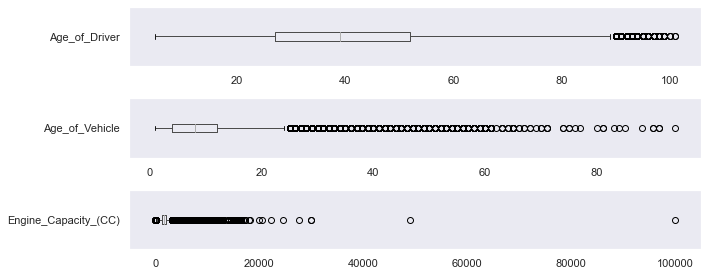

In [14]:
# plotting boxplots
sns.set(style='darkgrid')
fig, axes = plt.subplots(3,1, figsize=(10,4))

for ax, col in zip(axes, num_col):
    df.boxplot(column=col, grid=False, vert=False, ax=ax)
    plt.tight_layout();

In [15]:
# phrasing condition
condition = (df['Engine_Capacity_(CC)'] < 20000)

# keep only records that meet the condition and don't fall within extreme outliers
df = df[condition]

#### 2.4 Handling categorical data

In [16]:
# one-hot encoding for categorical data
dummies = pd.get_dummies(df[datetime_col + cat_col].astype('category'), drop_first=True) 

# concatenate all the features 
features = pd.concat([df[num_col], dummies], axis=1)

# define our target
target = df[['Accident_Severity']]

## 3. Training, validating, and testing model

#### 3.1 Handling imbalanced data 
In this part, I found that the data wasn't balance, so I did some works to make the data balanced. 

In [17]:
# import model tools
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import KFold, cross_validate
from imblearn.over_sampling import SMOTE

In [18]:
df['Accident_Severity'].value_counts()

3    462906
2     92291
1      8020
Name: Accident_Severity, dtype: int64

In [19]:
# Handling imbalanced data with SMOTE

print('Before Upsampling with SMOTE:'), print(target['Accident_Severity'].value_counts())

X_resampled, y_resampled = SMOTE().fit_sample(features, target)

print('\nAfter Upsampling with SMOTE:'), print(y_resampled['Accident_Severity'].value_counts())

Before Upsampling with SMOTE:
3    462906
2     92291
1      8020
Name: Accident_Severity, dtype: int64

After Upsampling with SMOTE:
3    462906
2    462906
1    462906
Name: Accident_Severity, dtype: int64


(None, None)

#### 3.2 Select model by cross validation

In [20]:
# split resampled data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, random_state=0)

In [32]:
# training model
model_tree = DecisionTreeClassifier()
model_tree.fit(X_train, y_train)
y_test_preds = model_tree.predict(X_test)

report = classification_report(y_test, y_test_preds)
print('Classification Report DecisionTree - with Entropy and SMOTE Upsampling: \n', report)

Classification Report DecisionTree - with Entropy and SMOTE Upsampling: 
               precision    recall  f1-score   support

           1       0.94      0.96      0.95    116180
           2       0.77      0.79      0.78    115478
           3       0.82      0.78      0.80    115522

    accuracy                           0.84    347180
   macro avg       0.84      0.84      0.84    347180
weighted avg       0.84      0.84      0.84    347180



In [22]:
model_tree_cro = cross_validate(model_tree, X_train, y_train, scoring='f1_macro', return_train_score=True, cv=3)

In [23]:
model_tree_cro

{'fit_time': array([35.00040221, 36.0474689 , 37.77737594]),
 'score_time': array([0.96884322, 1.20327306, 1.06303167]),
 'test_score': array([0.8251621, 0.8242738, 0.8244997]),
 'train_score': array([0.99992515, 0.99993811, 0.99993091])}

In [24]:
# training model
model_forest = RandomForestClassifier()
model_forest.fit(X_train, y_train)
y_test_preds = model_forest.predict(X_test)

report = classification_report(y_test, y_test_preds)
print('Classification Report Random Forest - with Entropy and SMOTE Upsampling: \n', report)

Classification Report Random Forest - with Entropy and SMOTE Upsampling: 
               precision    recall  f1-score   support

           1       0.97      0.98      0.98    116180
           2       0.91      0.79      0.85    115478
           3       0.83      0.93      0.88    115522

    accuracy                           0.90    347180
   macro avg       0.91      0.90      0.90    347180
weighted avg       0.91      0.90      0.90    347180



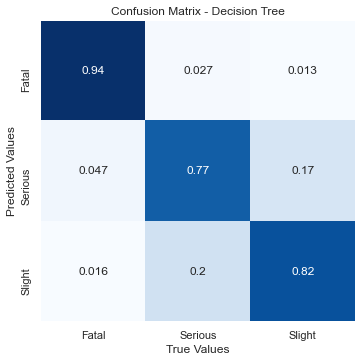

In [27]:
# create confusion matrix
y_test_preds = model_tree.predict(X_test)
matrix = confusion_matrix(y_test, y_test_preds, normalize='pred')

# create dataframe
class_names = df.Accident_Severity.values
dataframe = pd.DataFrame(matrix, index=['Fatal', 'Serious', 'Slight'], 
                         columns=['Fatal', 'Serious', 'Slight'])

# create heatmap
plt.figure(figsize=(5,5))
sns.heatmap(dataframe, annot=True, cbar=None, cmap='Blues')
plt.title('Confusion Matrix - Decision Tree')
plt.tight_layout(), plt.xlabel('True Values'), plt.ylabel('Predicted Values')

plt.show()

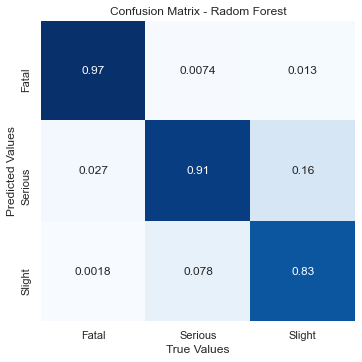

In [31]:
# create confusion matrix
y_test_preds = model_forest.predict(X_test)
matrix = confusion_matrix(y_test, y_test_preds, normalize='pred')
# create dataframe
class_names = df.Accident_Severity.values
dataframe = pd.DataFrame(matrix, index=['Fatal', 'Serious', 'Slight'], 
                         columns=['Fatal', 'Serious', 'Slight'])

# create heatmap
plt.figure(figsize=(5,5))
sns.heatmap(dataframe, annot=True, cbar=None, cmap='Blues')
plt.title('Confusion Matrix - Radom Forest')
plt.tight_layout(), plt.xlabel('True Values'), plt.ylabel('Predicted Values')

plt.show()

Text(0.5, 0, 'Relative Feature Importance with Random Forest')

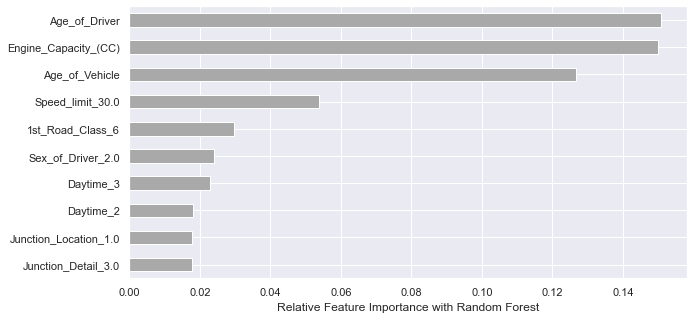

In [26]:
# plot the important features
feat_importances = pd.Series(model_forest.feature_importances_, index=features.columns)
feat_importances.nlargest(10).sort_values().plot(kind='barh', color='darkgrey', figsize=(10,5))
plt.xlabel('Relative Feature Importance with Random Forest')